# Import Libraries and set seeds

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pylab
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

import json
import pickle
import random as python_random
import os


import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import ResNet50, InceptionResNetV2

from keras import models, layers
from keras.optimizers import RMSprop, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint

np.random.seed(123)
python_random.seed(123)
tf.random.set_seed(1234)

IMG_SIZE_1 = 224
IMG_SIZE_2 = 299

# Load Dataset

In [ ]:
df = pd.read_csv('./meta.csv')

train_df, test_df = train_test_split(df, test_size=0.2, random_state=0, stratify=df['gender'])
train_df, val_df = train_test_split(train_df, test_size=0.3, random_state=0, stratify=train_df['gender'])

train_datagen = ImageDataGenerator(rescale=1./255)
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Functions

In [ ]:
def generate_data(train_df, val_df, test_df, img_size, batch_size):
  # data generator for training data
  train_generator = train_datagen.flow_from_dataframe(train_df, x_col="path", 
                                                      y_col="gender", 
                                                      target_size=(img_size,img_size), 
                                                      batch_size=batch_size, 
                                                      class_mode='binary')

  # data generator for validation data
  validation_generator = validation_datagen.flow_from_dataframe(val_df, x_col="path", 
                                                                y_col="gender", 
                                                                target_size=(img_size,img_size),
                                                                batch_size=batch_size, 
                                                                class_mode='binary')

  # data generator for testing data
  test_generator = test_datagen.flow_from_dataframe(test_df, x_col="path", 
                                                    y_col="gender", 
                                                    target_size=(img_size,img_size),
                                                    batch_size=batch_size, 
                                                    class_mode='binary',
                                                    shuffle = False)
  
  generators = {'train_gen': train_generator,
                'validation_gen': validation_generator,
                'test_gen': test_generator}
  
  return generators

In [ ]:
# Define EarlyStopping callback
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=7, restore_best_weights=True)

# Define Model Checkpoint callback
def mc(title, save_path):
  save_path = '{}/{}_mc.h5'.format(save_path, title)
  return ModelCheckpoint(save_path, monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [ ]:
def plot_history(history, title, save_path=None):
  pylab.figure(figsize=(12,4))
  pylab.subplot(1,2,1)
  pylab.plot(history.history['acc'], label='train')
  pylab.plot(history.history['val_acc'], label='validation')
  pylab.title('Model Accuracy for {}'.format(title))
  pylab.xlabel('epochs')
  pylab.ylabel('accuracy')
  pylab.legend(loc='lower right')

  pylab.subplot(1,2,2)
  pylab.plot(history.history['loss'], label='train')
  pylab.plot(history.history['val_loss'], label='validation')
  pylab.title('Model Loss for {}'.format(title))
  pylab.xlabel('epochs')
  pylab.ylabel('loss')
  pylab.legend(loc='upper right')
  
  if save_path:
    pylab.savefig('{}/{}.pdf'.format(save_path, title))

In [ ]:
def fit(model, epochs, title, generator, es, save_path):
  train_gen = generator['train_gen']
  validation_gen = generator['validation_gen']
  history = model.fit(train_gen, 
                      steps_per_epoch=train_gen.samples/train_gen.batch_size, 
                      epochs=epochs,
                      validation_data=validation_gen,
                      validation_steps=validation_gen.samples/validation_gen.batch_size,
                      verbose=1,
                      callbacks=[es, mc(title, save_path)])

  return history

In [ ]:
def save_history(history, save_path, title):
  # Saving history to file
  filename = '{}/{}_hist'.format(save_path, title)
  with open(filename, 'wb') as file_pi:
      pickle.dump(history.history, file_pi)
  print("Successfully saved history file at {}".format(filename))

In [ ]:
def model_analysis(model, generator, title, save_path):
  print('Results for {}'.format(title))
  test_gen = generator['validation_gen']
  prediction = model.predict(test_gen,
                             steps=test_gen.samples/test_gen.batch_size,
                             verbose=2)
  predicted_classes = prediction.flatten()
  predicted_classes[predicted_classes>=0.5] = 1
  predicted_classes[predicted_classes<0.5] = 0
  
  actual = test_gen.classes
  errors = np.where(predicted_classes != actual)[0]
  print("Error rate {}".format(len(errors)/test_gen.samples))
  
  genders = ['Female', 'Male']
  cm = confusion_matrix(actual, predicted_classes)
  sns.heatmap(cm, annot=True, cmap='Blues', fmt="d",
              xticklabels=genders, yticklabels=genders)
  
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig('{}/{}_cm.pdf'.format(save_path, title))
  plt.close()
  
  print(classification_report(actual, predicted_classes, target_names=genders))
  clsf_report = pd.DataFrame(classification_report(actual, predicted_classes, target_names=genders, output_dict=True)).transpose()
  clsf_report.to_csv('{}/{}_cr.csv'.format(save_path, title), index= True)

  # Get AUC ROC Score and save as a file
  roc_auc = roc_auc_score(actual, predicted_classes)
  roc_auc_file = '{}/{}_roc_auc'.format(save_path, title)
  params = {'title': title,
            'roc_auc': roc_auc}
  with open(roc_auc_file, 'w') as fp:
    json.dump(params, fp)
  print("Successfully saved auc_roc file at {}".format(roc_auc_file))

In [ ]:
path = './drive/MyDrive/nn_project/inception_resnet/stacked_inc_res/stacked_inc_res_mc.h5'
from keras.models import load_model
stacked_model = load_model(path)

In [ ]:
stacked_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 8, 8, 1536)        54336736  
_________________________________________________________________
flatten_2 (Flatten)          (None, 98304)             0         
_________________________________________________________________
dense_6 (Dense)              (None, 1024)              100664320 
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                

In [ ]:
# Prepare data for base model
generators = generate_data(train_df, val_df, test_df, IMG_SIZE_1, 128)

Found 22520 validated image filenames belonging to 2 classes.
Found 9652 validated image filenames belonging to 2 classes.
Found 8044 validated image filenames belonging to 2 classes.


In [ ]:
generators.keys()

dict_keys(['train_gen', 'validation_gen', 'test_gen'])

In [ ]:
model_analysis(stacked_model, generators, 'test', './drive')

Results for test


InvalidArgumentError: ignored

In [ ]:
def save_model_params(title, batch_size, epochs, lr, num_neurons, dropout, opt, n_layers=1, save_path='.'):
  params_file = '{}/{}_params'.format(save_path, title)
  params = {'title': title,
            'batch_size': batch_size,
            'epochs': epochs,
            'learning_rate': lr,
            'num_neurons': num_neurons,
            'dropout_rate': dropout,
            'optimiser': opt}
  with open(params_file, 'w') as fp:
    json.dump(params, fp)
  print("Successfully saved params file at {}".format(params_file))

# Train with base model set-up

In [ ]:
# Base Model Parameters
BATCH_SIZE = 128
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_NEURONS = 1024
DROPOUT_RATE = 0.5
MOMENTUM = 0.9
OPTIMISER = 'SGD'

## ResNet50

In [ ]:
resnet50 = ResNet50(weights='imagenet', include_top=False, input_tensor=None, input_shape=(224,224,3))
resnet50.summary()

94773248/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
for layer in resnet50.layers:
  if layer.name == 'conv1_conv':
    test_layer = layer

### Set Parameters for Base ResNet50

In [ ]:
# Parameters for Base ResNet50
TITLE = 'base_resnet50'
SAVE_PATH = './drive/My Drive/nn_project/resnet50/base_resnet50'

if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

# Prepare data for base model
generators = generate_data(train_df, val_df, test_df, IMG_SIZE_1, BATCH_SIZE)

Found 22520 validated image filenames belonging to 2 classes.
Found 9652 validated image filenames belonging to 2 classes.
Found 8044 validated image filenames belonging to 2 classes.


### Create Model for Base ResNet50

In [ ]:
# Download ResNet50 weights
resnet50_conv = ResNet50(weights='imagenet', include_top=False, input_tensor=None, input_shape=(224,224,3))

# freeze all layers except stage 4
for layer in resnet50_conv.layers[:143]:
  layer.trainable = False
for layer in resnet50_conv.layers[143:]:
  layer.trainable = True

# Build base model
base_resnet50 = models.Sequential()
base_resnet50.add(resnet50_conv)      #Feature extraction (convolutional layers)
base_resnet50.add(layers.Flatten())   # adding new Dense Layers
base_resnet50.add(layers.Dense(NUM_NEURONS, activation='relu'))
base_resnet50.add(layers.Dropout(DROPOUT_RATE))
base_resnet50.add(layers.Dense(1, activation='sigmoid'))

# Compile base model
base_resnet50.compile(loss='binary_crossentropy', 
                      optimizer=SGD(lr=LEARNING_RATE, momentum=MOMENTUM),
                      metrics=['acc'])

### Train (Fit) Base ResNet50 & save information

In [ ]:
# Train and save the history of training + params of model
base_resnet50_hist = fit(base_resnet50, EPOCHS, TITLE, generators, es, SAVE_PATH)

save_history(base_resnet50_hist, SAVE_PATH, TITLE)
save_model_params(TITLE, BATCH_SIZE, EPOCHS, LEARNING_RATE, NUM_NEURONS, 
                  DROPOUT_RATE, OPTIMISER, SAVE_PATH)

Epoch 1/40
176/175 [==============================] - ETA: 0s - loss: 0.5319 - acc: 0.7640
Epoch 00001: val_acc improved from -inf to 0.72182, saving model to ./drive/My Drive/nn_project/resnet50/base_resnet50/base_resnet50_mc.h5
176/175 [==============================] - 163s 923ms/step - loss: 0.5319 - acc: 0.7640 - val_loss: 0.5895 - val_acc: 0.7218
Epoch 2/40
176/175 [==============================] - ETA: 0s - loss: 0.4308 - acc: 0.8119
Epoch 00002: val_acc improved from 0.72182 to 0.80781, saving model to ./drive/My Drive/nn_project/resnet50/base_resnet50/base_resnet50_mc.h5
176/175 [==============================] - 138s 785ms/step - loss: 0.4308 - acc: 0.8119 - val_loss: 0.4433 - val_acc: 0.8078
Epoch 3/40
176/175 [==============================] - ETA: 0s - loss: 0.3930 - acc: 0.8350
Epoch 00003: val_acc improved from 0.80781 to 0.82232, saving model to ./drive/My Drive/nn_project/resnet50/base_resnet50/base_resnet50_mc.h5
176/175 [==============================] - 137s 777ms/

KeyboardInterrupt: ignored

### Plot History for Base ResNet50

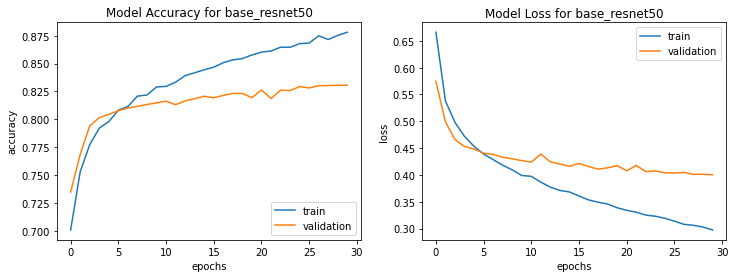

In [ ]:
# Plot accuracy and loss of model
plot_history(base_resnet50_hist, title=TITLE, save_path=SAVE_PATH)

### Visualise the results of Base ResNet50's Prediction

Results for base_resnet50
63/62 [==============================] - 21s 339ms/step
Error rate 0.16894579811039284
              precision    recall  f1-score   support

      Female       0.74      0.54      0.63      2098
        Male       0.85      0.93      0.89      5946

    accuracy                           0.83      8044
   macro avg       0.80      0.74      0.76      8044
weighted avg       0.82      0.83      0.82      8044



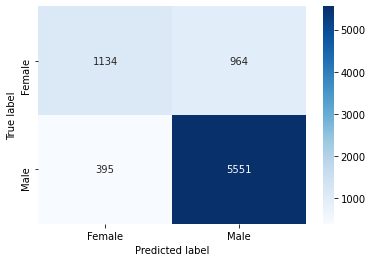

In [ ]:
# Print and visualise the results
model_analysis(base_resnet50, generators, TITLE, SAVE_PATH)

## InceptionResNet Base Model

### Set Parameters for Base InceptionResNet

In [ ]:
# Parameters for Base InceptionResNet
TITLE = 'base_inc_res'
SAVE_PATH = './drive/My Drive/nn_project/inception_resnet/base_inc_res'
START_LAYER = 759
LAST_LAYER = 780

if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

# Prepare data for base model
generators = generate_data(train_df, val_df, test_df, IMG_SIZE_2, BATCH_SIZE)

Found 22520 validated image filenames belonging to 2 classes.
Found 9652 validated image filenames belonging to 2 classes.
Found 8044 validated image filenames belonging to 2 classes.


In [ ]:
# Download InceptionResNet weights
incResV2_conv = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=None, input_shape=(299,299,3))
incResV2_conv.summary()

219062272/219055592 [==============================] - 1s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 299, 299, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 149, 149, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 149, 149, 32) 0           batch_normalization[0][0]        
_____________

### Create Model for Base InceptionResNet

In [ ]:
# Download InceptionResNet weights
incResV2_conv = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=None, input_shape=(299,299,3))

# freeze all layers except last block
for layer in incResV2_conv.layers[:START_LAYER]:
  layer.trainable = False
for layer in incResV2_conv.layers[START_LAYER:]:
  layer.trainable = True

# Build base model
base_inc_res = models.Sequential()
base_inc_res.add(incResV2_conv)             # Feature extraction (convolutional layers)
base_inc_res.add(layers.Flatten())          # adding new Dense Layers
base_inc_res.add(layers.Dense(NUM_NEURONS, activation='relu'))
base_inc_res.add(layers.Dropout(DROPOUT_RATE))
base_inc_res.add(layers.Dense(1, activation='sigmoid'))

# Compile base model
base_inc_res.compile(loss='binary_crossentropy', 
                     optimizer=SGD(lr=LEARNING_RATE, momentum=MOMENTUM),
                     metrics=['acc'])

### Train (Fit) Base InceptionResNet & save information

In [ ]:
# Train and save the history of training + params of model
base_inc_res_hist = fit(base_inc_res, EPOCHS, TITLE, generators, es, SAVE_PATH)

save_history(base_inc_res_hist, SAVE_PATH, TITLE)
save_model_params(TITLE, BATCH_SIZE, EPOCHS, LEARNING_RATE, NUM_NEURONS, 
                  DROPOUT_RATE, OPTIMISER, SAVE_PATH)

Epoch 1/40
111/175 [=================>............] - ETA: 1:26 - loss: 0.3931 - acc: 0.8337

KeyboardInterrupt: ignored

### Plot History for Base InceptionResNet

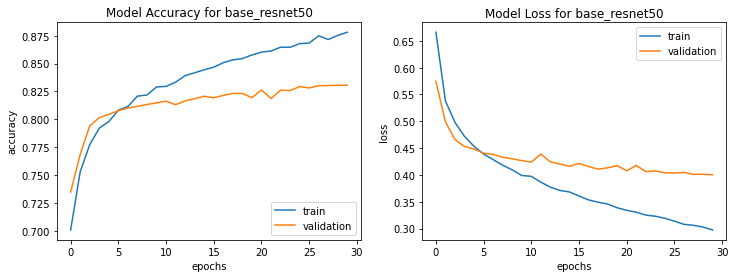

In [ ]:
# Plot accuracy and loss of model
plot_history(base_inc_res_hist, title=TITLE, save_path=SAVE_PATH)

### Visualise the results of Base InceptionResNet's Prediction

Results for base_resnet50
63/62 [==============================] - 21s 339ms/step
Error rate 0.16894579811039284
              precision    recall  f1-score   support

      Female       0.74      0.54      0.63      2098
        Male       0.85      0.93      0.89      5946

    accuracy                           0.83      8044
   macro avg       0.80      0.74      0.76      8044
weighted avg       0.82      0.83      0.82      8044



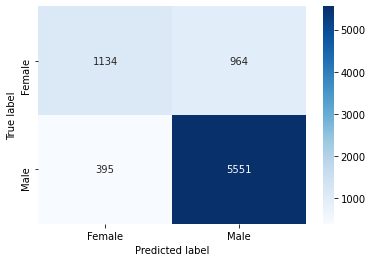

In [ ]:
# Print and visualise the results
model_analysis(base_inc_res, generators, TITLE, SAVE_PATH)

# InceptionResNet Tuning

## Batch Size

### Set Parameters for Batch Sizes

In [ ]:
TITLE = 'bs_inc_res'
BATCH_SIZE = [64, 128, 256]
EPOCHS = 30
LEARNING_RATE = 1e-4
NUM_NEURONS = 1024
DROPOUT_RATE = 0.5
MOMENTUM = 0.9
OPTIMISER = 'SGD'
START_LAYER = 759
LAST_LAYER = 780

SAVE_PATH = './drive/My Drive/nn_project/inception_resnet/bs_inc_res'

if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

bs_generators = {}
# Prepare data for base model
for bs in BATCH_SIZE:
  bs_generators[bs] = generate_data(train_df, val_df, test_df, IMG_SIZE_2, bs)

Found 22520 validated image filenames belonging to 2 classes.
Found 9652 validated image filenames belonging to 2 classes.
Found 8044 validated image filenames belonging to 2 classes.
Found 22520 validated image filenames belonging to 2 classes.
Found 9652 validated image filenames belonging to 2 classes.
Found 8044 validated image filenames belonging to 2 classes.
Found 22520 validated image filenames belonging to 2 classes.
Found 9652 validated image filenames belonging to 2 classes.
Found 8044 validated image filenames belonging to 2 classes.


### Create Model for Batch Sizes

In [ ]:
bs_inc_res_models = []
for bs in BATCH_SIZE:
  # Download InceptionResNet weights
  incResV2_conv = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=None, input_shape=(299,299,3))

  # freeze all layers except last block
  for layer in incResV2_conv.layers[:START_LAYER]:
    layer.trainable = False
  for layer in incResV2_conv.layers[START_LAYER:]:
    layer.trainable = True

  # Build model
  model = models.Sequential()
  model.add(incResV2_conv)             # Feature extraction (convolutional layers)
  model.add(layers.Flatten())          # adding new Dense Layers
  model.add(layers.Dense(NUM_NEURONS, activation='relu'))
  model.add(layers.Dropout(DROPOUT_RATE))
  model.add(layers.Dense(1, activation='sigmoid'))

  bs_inc_res_models.append(model)

219062272/219055592 [==============================] - 2s 0us/step


### Train (Fit) Batch Sizes Model & save information

In [ ]:
# Train and save the history of training + params of model
bs_history = {}

for model, bs, gen in zip(bs_inc_res_models, BATCH_SIZE, bs_generators):
  model.compile(loss='binary_crossentropy', 
                optimizer=SGD(lr=LEARNING_RATE, momentum=MOMENTUM),
                metrics=['acc'])
  
  title = '{}_{}'.format(TITLE, bs)
  print('Running {}'.format(title))
  bs_history[bs] = fit(model, EPOCHS, title, bs_generators[gen], es, SAVE_PATH)
  save_history(bs_history[bs], SAVE_PATH, title)
  save_model_params(title, bs, EPOCHS, LEARNING_RATE, NUM_NEURONS, 
                   DROPOUT_RATE, OPTIMISER, SAVE_PATH)

Running bs_inc_res_256
Epoch 1/40
88/87 [==============================] - ETA: 0s - loss: 0.4223 - acc: 0.8219
Epoch 00001: val_acc improved from -inf to 0.89329, saving model to ./drive/My Drive/nn_project/inception_resnet/bs_inc_res/bs_inc_res_256_mc.h5
88/87 [==============================] - 365s 4s/step - loss: 0.4223 - acc: 0.8219 - val_loss: 0.2913 - val_acc: 0.8933
Epoch 2/40
88/87 [==============================] - ETA: 0s - loss: 0.3028 - acc: 0.8838
Epoch 00002: val_acc improved from 0.89329 to 0.90023, saving model to ./drive/My Drive/nn_project/inception_resnet/bs_inc_res/bs_inc_res_256_mc.h5
88/87 [==============================] - 338s 4s/step - loss: 0.3028 - acc: 0.8838 - val_loss: 0.2736 - val_acc: 0.9002
Epoch 3/40
88/87 [==============================] - ETA: 0s - loss: 0.2839 - acc: 0.8916
Epoch 00003: val_acc improved from 0.90023 to 0.90365, saving model to ./drive/My Drive/nn_project/inception_resnet/bs_inc_res/bs_inc_res_256_mc.h5
88/87 [======================

KeyboardInterrupt: ignored

### Plot History for Batch Sizes

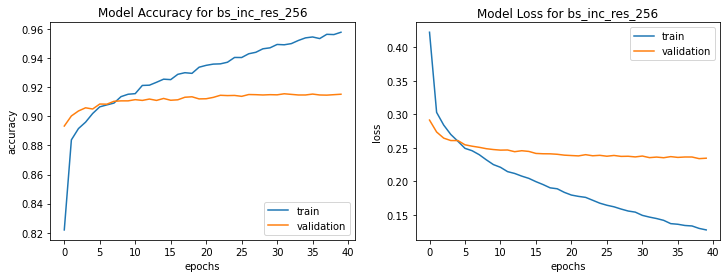

In [ ]:
# Plot accuracy and loss of model
for bs in bs_history:
  title = '{}_{}'.format(TITLE, bs)
  plot_history(bs_history[bs], title, SAVE_PATH)

### Visualise the results of Batch Sizes Prediction

In [ ]:
# Print and visualise the results
for model, bs, gen in zip(bs_inc_res_models, BATCH_SIZE, bs_generators):
  title = '{}_{}'.format(TITLE, bs)
  model_analysis(model, bs_generators[gen], title, SAVE_PATH)

Results for bs_inc_res_256
32/31 [==============================] - 82s 3s/step
Error rate 0.09075087021382397
              precision    recall  f1-score   support

      Female       0.88      0.75      0.81      2098
        Male       0.92      0.97      0.94      5946

    accuracy                           0.91      8044
   macro avg       0.90      0.86      0.88      8044
weighted avg       0.91      0.91      0.91      8044

Results for bs_inc_res_128
63/62 [==============================] - 79s 1s/step
Error rate 0.09037792143212332
              precision    recall  f1-score   support

      Female       0.88      0.75      0.81      2098
        Male       0.92      0.97      0.94      5946

    accuracy                           0.91      8044
   macro avg       0.90      0.86      0.88      8044
weighted avg       0.91      0.91      0.91      8044



## Dropout

### Set Parameters for Dropouts

In [ ]:
TITLE = 'dropout_inc_res'
BATCH_SIZE = 128
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_NEURONS = 1024
DROPOUT_RATE = [0, 0.2, 0.5]
MOMENTUM = 0.9
OPTIMISER = 'SGD'

SAVE_PATH = './drive/My Drive/nn_project/inception_resnet/dropout_inc_res'

if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

# Prepare data for model
generators = generate_data(train_df, val_df, test_df, IMG_SIZE_2, bs)

### Create Model for Dropouts

In [ ]:
dropout_inc_res_models = []
for dropout in DROPOUT_RATE:
  # Download InceptionResNet weights
  incResV2_conv = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=None, input_shape=(299,299,3))

  # freeze all layers except last block
  for layer in incResV2_conv.layers[:742]:
    layer.trainable = False
  for layer in incResV2_conv.layers[742:]:
    layer.trainable = True

  # Build model
  model = models.Sequential()
  model.add(incResV2_conv)             # Feature extraction (convolutional layers)
  model.add(layers.Flatten())          # adding new Dense Layers
  model.add(layers.Dense(NUM_NEURONS, activation='relu'))
  model.add(layers.Dropout(dropout))
  model.add(layers.Dense(1, activation='sigmoid'))

  dropout_inc_res_models.append(model)

### Train (Fit) Dropout Model & save information

In [ ]:
# Train and save the history of training + params of model
dropout_history = {}

for model, dropout in zip(dropout_inc_res_models, DROPOUT_RATE):
  model.compile(loss='binary_crossentropy', 
                optimizer=SGD(lr=LEARNING_RATE, momentum=MOMENTUM),
                metrics=['acc'])
  
  title = '{}_{}'.format(TITLE, dropout)
  print('Running {}'.format(title))
  dropout_history[dropout] = fit(model, EPOCHS, title, generators, es, SAVE_PATH)
  save_history(dropout_history[dropout], SAVE_PATH, title)
  save_model_params(title, BATCH_SIZE, EPOCHS, LEARNING_RATE, NUM_NEURONS, 
                   dropout, OPTIMISER, SAVE_PATH)

Epoch 1/30
176/175 [==============================] - ETA: 0s - loss: 0.6661 - acc: 0.7008
Epoch 00001: val_acc improved from -inf to 0.73477, saving model to ./mc_base_resnet50.h5
176/175 [==============================] - 97s 551ms/step - loss: 0.6661 - acc: 0.7008 - val_loss: 0.5747 - val_acc: 0.7348
Epoch 2/30
176/175 [==============================] - ETA: 0s - loss: 0.5380 - acc: 0.7530
Epoch 00002: val_acc improved from 0.73477 to 0.76865, saving model to ./mc_base_resnet50.h5
176/175 [==============================] - 89s 504ms/step - loss: 0.5380 - acc: 0.7530 - val_loss: 0.4990 - val_acc: 0.7686
Epoch 3/30
176/175 [==============================] - ETA: 0s - loss: 0.4980 - acc: 0.7773
Epoch 00003: val_acc improved from 0.76865 to 0.79414, saving model to ./mc_base_resnet50.h5
176/175 [==============================] - 90s 511ms/step - loss: 0.4980 - acc: 0.7773 - val_loss: 0.4659 - val_acc: 0.7941
Epoch 4/30
176/175 [==============================] - ETA: 0s - loss: 0.4719 - 

### Plot History for Dropouts

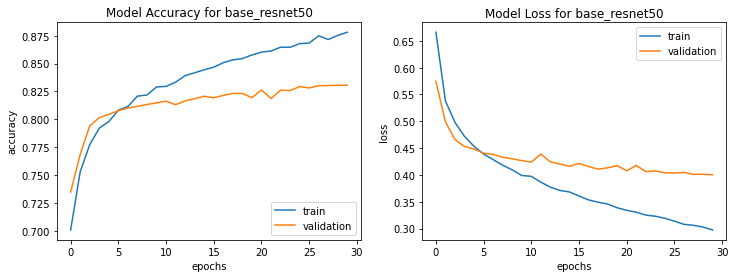

In [ ]:
# Plot accuracy and loss of model
for dropout in dropout_history:
  title = '{}_{}'.format(TITLE, dropout)
  plot_history(dropout_history[dropout], title, SAVE_PATH)

### Visualise the results of Dropouts Prediction

Results for base_resnet50
63/62 [==============================] - 21s 339ms/step
Error rate 0.16894579811039284
              precision    recall  f1-score   support

      Female       0.74      0.54      0.63      2098
        Male       0.85      0.93      0.89      5946

    accuracy                           0.83      8044
   macro avg       0.80      0.74      0.76      8044
weighted avg       0.82      0.83      0.82      8044



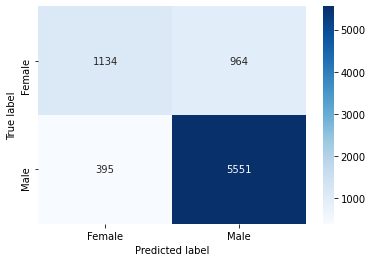

In [ ]:
# Print and visualise the results
for model, dropout in zip(dropout_inc_res_models, DROPOUT_RATE):
  title = '{}_{}'.format(TITLE, dropout)
  model_analysis(model, generators, title, SAVE_PATH)

## Learning Rate

### Set Parameters for Learning Rate

In [ ]:
TITLE = 'lr_inc_res'
BATCH_SIZE = 128
EPOCHS = 40
LEARNING_RATE = [1e-2, 1e-3, 1e-4]
NUM_NEURONS = 1024
DROPOUT_RATE = 0.5
MOMENTUM = 0.9
OPTIMISER = 'SGD'

SAVE_PATH = './drive/My Drive/nn_project/inception_resnet/lr_inc_res'

if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

# Prepare data for model
generators = generate_data(train_df, val_df, test_df, IMG_SIZE_2, bs)

### Create Model for Dropouts

In [ ]:
lr_inc_res_models = []
for lr in LEARNING_RATE:
  # Download InceptionResNet weights
  incResV2_conv = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=None, input_shape=(299,299,3))

  # freeze all layers except last block
  for layer in incResV2_conv.layers[:742]:
    layer.trainable = False
  for layer in incResV2_conv.layers[742:]:
    layer.trainable = True

  # Build model
  model = models.Sequential()
  model.add(incResV2_conv)             # Feature extraction (convolutional layers)
  model.add(layers.Flatten())          # adding new Dense Layers
  model.add(layers.Dense(NUM_NEURONS, activation='relu'))
  model.add(layers.Dropout(DROPOUT_RATE))
  model.add(layers.Dense(1, activation='sigmoid'))

  lr_inc_res_models.append(model)

### Train (Fit) Dropout Model & save information

In [ ]:
# Train and save the history of training + params of model
lr_history = {}

for model, lr in zip(lr_inc_res_models, LEARNING_RATE):
  model.compile(loss='binary_crossentropy', 
                optimizer=SGD(lr=lr, momentum=MOMENTUM),
                metrics=['acc'])
  
  title = '{}_{}'.format(TITLE, lr)
  print('Running {}'.format(title))
  lr_history[lr] = fit(model, EPOCHS, title, generators, es, SAVE_PATH)
  save_history(lr_history[lr], SAVE_PATH, title)
  save_model_params(title, BATCH_SIZE, EPOCHS, lr, NUM_NEURONS, 
                   DROPOUT_RATE, OPTIMISER, SAVE_PATH)

Epoch 1/30
176/175 [==============================] - ETA: 0s - loss: 0.6661 - acc: 0.7008
Epoch 00001: val_acc improved from -inf to 0.73477, saving model to ./mc_base_resnet50.h5
176/175 [==============================] - 97s 551ms/step - loss: 0.6661 - acc: 0.7008 - val_loss: 0.5747 - val_acc: 0.7348
Epoch 2/30
176/175 [==============================] - ETA: 0s - loss: 0.5380 - acc: 0.7530
Epoch 00002: val_acc improved from 0.73477 to 0.76865, saving model to ./mc_base_resnet50.h5
176/175 [==============================] - 89s 504ms/step - loss: 0.5380 - acc: 0.7530 - val_loss: 0.4990 - val_acc: 0.7686
Epoch 3/30
176/175 [==============================] - ETA: 0s - loss: 0.4980 - acc: 0.7773
Epoch 00003: val_acc improved from 0.76865 to 0.79414, saving model to ./mc_base_resnet50.h5
176/175 [==============================] - 90s 511ms/step - loss: 0.4980 - acc: 0.7773 - val_loss: 0.4659 - val_acc: 0.7941
Epoch 4/30
176/175 [==============================] - ETA: 0s - loss: 0.4719 - 

### Plot History for Learning Rate

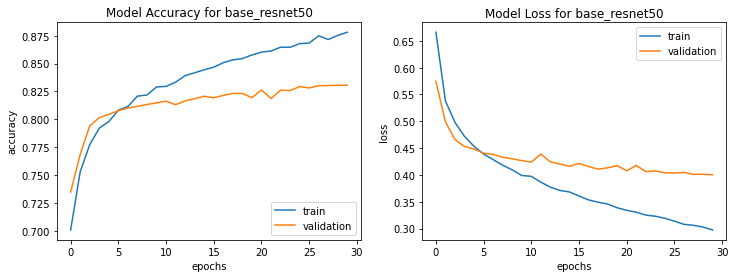

In [ ]:
# Plot accuracy and loss of model
for lr in lr_history:
  title = '{}_{}'.format(TITLE, lr)
  plot_history(lr_history[lr], title, SAVE_PATH)

### Visualise the results of Learning Rate Prediction

Results for base_resnet50
63/62 [==============================] - 21s 339ms/step
Error rate 0.16894579811039284
              precision    recall  f1-score   support

      Female       0.74      0.54      0.63      2098
        Male       0.85      0.93      0.89      5946

    accuracy                           0.83      8044
   macro avg       0.80      0.74      0.76      8044
weighted avg       0.82      0.83      0.82      8044



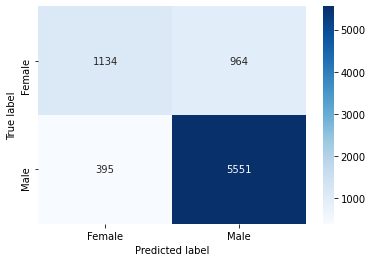

In [ ]:
# Print and visualise the results
for model, lr in zip(lr_inc_res_models, LEARNING_RATE):
  title = '{}_{}'.format(TITLE, lr)
  model_analysis(model, generators, title, SAVE_PATH)

## Stacked

### Set Parameters for Learning Rate

In [ ]:
TITLE = 'stacked_inc_res'
BATCH_SIZE = 128
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_NEURONS = 1024
DROPOUT_RATE = 0.5
MOMENTUM = 0.9
OPTIMISER = 'SGD'

SAVE_PATH = './drive/My Drive/nn_project/inception_resnet/stacked_inc_res
if not os.path.exists(SAVE_PATH):
    os.mkdir(SAVE_PATH)

# Prepare data for model
generators = generate_data(train_df, val_df, test_df, IMG_SIZE_2, bs)

### Create Model for Stacked

In [ ]:
# Download InceptionResNet weights
incResV2_conv = InceptionResNetV2(weights='imagenet', include_top=False, input_tensor=None, input_shape=(299,299,3))

# freeze all layers except last block
for layer in incResV2_conv.layers[:742]:
  layer.trainable = False
for layer in incResV2_conv.layers[742:]:
  layer.trainable = True

# Build model
stacked_model = models.Sequential()
stacked_model.add(incResV2_conv)             # Feature extraction (convolutional layers)
stacked_model.add(layers.Flatten())          # adding new Dense Layers
stacked_model.add(layers.Dense(NUM_NEURONS, activation='relu'))
stacked_model.add(layers.Dropout(DROPOUT_RATE))
stacked_model.add(layers.Dense(NUM_NEURONS, activation='relu'))
stacked_model.add(layers.Dropout(DROPOUT_RATE))
stacked_model.add(layers.Dense(1, activation='sigmoid'))

### Train (Fit) Stacked Model & save information

In [ ]:
# Train and save the history of training + params of model
stacked_model.compile(loss='binary_crossentropy', 
                      optimizer=SGD(lr=LEARNING_RATE, momentum=MOMENTUM),
                      metrics=['acc'])

stacked_history = fit(stacked_model, EPOCHS, TITLE, generators, es, SAVE_PATH)
save_history(stacked_history, SAVE_PATH, TITLE)
save_model_params(TITLE, BATCH_SIZE, EPOCHS, LEARNING_RATE, NUM_NEURONS, 
                  DROPOUT_RATE, OPTIMISER, n_layers=2, SAVE_PATH)

Epoch 1/30
176/175 [==============================] - ETA: 0s - loss: 0.6661 - acc: 0.7008
Epoch 00001: val_acc improved from -inf to 0.73477, saving model to ./mc_base_resnet50.h5
176/175 [==============================] - 97s 551ms/step - loss: 0.6661 - acc: 0.7008 - val_loss: 0.5747 - val_acc: 0.7348
Epoch 2/30
176/175 [==============================] - ETA: 0s - loss: 0.5380 - acc: 0.7530
Epoch 00002: val_acc improved from 0.73477 to 0.76865, saving model to ./mc_base_resnet50.h5
176/175 [==============================] - 89s 504ms/step - loss: 0.5380 - acc: 0.7530 - val_loss: 0.4990 - val_acc: 0.7686
Epoch 3/30
176/175 [==============================] - ETA: 0s - loss: 0.4980 - acc: 0.7773
Epoch 00003: val_acc improved from 0.76865 to 0.79414, saving model to ./mc_base_resnet50.h5
176/175 [==============================] - 90s 511ms/step - loss: 0.4980 - acc: 0.7773 - val_loss: 0.4659 - val_acc: 0.7941
Epoch 4/30
176/175 [==============================] - ETA: 0s - loss: 0.4719 - 

### Plot History for Stacked

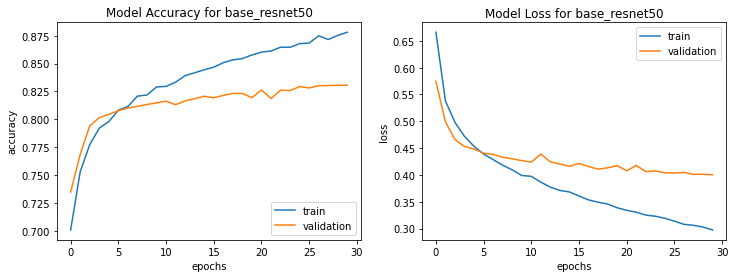

In [ ]:
# Plot accuracy and loss of model
plot_history(stacked_history, TITLE, SAVE_PATH)

### Visualise the results of Stacked Prediction

Results for base_resnet50
63/62 [==============================] - 21s 339ms/step
Error rate 0.16894579811039284
              precision    recall  f1-score   support

      Female       0.74      0.54      0.63      2098
        Male       0.85      0.93      0.89      5946

    accuracy                           0.83      8044
   macro avg       0.80      0.74      0.76      8044
weighted avg       0.82      0.83      0.82      8044



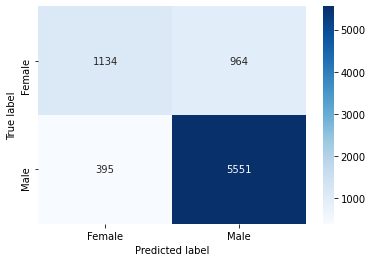

In [ ]:
# Print and visualise the results
model_analysis(stacked_model, generators, TITLE, SAVE_PATH)

# Load Back Results

In [ ]:
all_hist = {}
# Load back history for batch_size
BATCH_SIZES = [64,128,256]
for bs in BATCH_SIZES:
  title = 'bs_inc_res_{}'.format(bs)
  filename = './drive/MyDrive/nn_project/inception_resnet/bs_inc_res/bs_hist/{}_hist'.format(title)
  all_hist[title] = pickle.load(open(filename, "rb"))

LEARNING_RATES = [1e-2, 1e-3]
for lr in LEARNING_RATES:
  title = 'lr_inc_res_{}'.format(lr)
  filename = './drive/MyDrive/nn_project/inception_resnet/lr_inc_res/lr_hist/{}_hist'.format(title)
  all_hist[title] = pickle.load(open(filename, "rb"))

DROPOUT_RATES = [0, 0.2]
for dr in DROPOUT_RATES:
  title = 'dropout_inc_res_{}'.format(dr)
  filename = './drive/MyDrive/nn_project/inception_resnet/dropout_inc_res/dropout_hist/{}_hist'.format(title)
  all_hist[title] = pickle.load(open(filename, "rb"))

title = 'stacked_inc_res'
filename = './drive/MyDrive/nn_project/inception_resnet/stacked_inc_res/{}_hist'.format(title)
all_hist[title] = pickle.load(open(filename, "rb"))

In [ ]:
# Plot Max Validation Accuracies
print('Max Validation Accuracies')
max_acc = {}
max_model = {'name': None, 'val_acc': 0}
for model in all_hist.keys():
  max = np.max(all_hist[model]['val_acc'])
  epoch = np.argmax(all_hist[model]['val_acc']) + 1
  last_epoch = len(all_hist[model]['val_acc'])
  print('{:<20}: {} at epoch {:<2} where last epoch is {}'.format(model, max, epoch, last_epoch))
  if max > max_model['val_acc']:
    max_model['val_acc'] = max
    max_model['name'] = model
  max_acc[model] = max

print()
print('The best model is {} with val_acc of {}'.format(max_model['name'], max_model['val_acc']))

Max Validation Accuracies
bs_inc_res_64       : 0.9162867665290833 at epoch 20 where last epoch is 20
bs_inc_res_128      : 0.9186697006225586 at epoch 23 where last epoch is 30
bs_inc_res_256      : 0.9176336526870728 at epoch 28 where last epoch is 30
lr_inc_res_0.01     : 0.9221922755241394 at epoch 5  where last epoch is 9
lr_inc_res_0.001    : 0.9161831736564636 at epoch 8  where last epoch is 11
dropout_inc_res_0   : 0.9139038324356079 at epoch 20 where last epoch is 25
dropout_inc_res_0.2 : 0.9136966466903687 at epoch 26 where last epoch is 26
stacked_inc_res     : 0.9146291017532349 at epoch 30 where last epoch is 30

The best model is lr_inc_res_0.01 with val_acc of 0.9221922755241394


In [ ]:
filename = './drive/MyDrive/nn_project/inception_resnet/bs_inc_res/bs_256/bs_inc_res_256_mc.h5'
bs_256_model = models.load_model(filename)